TRAINING PHASE: Processing training images...


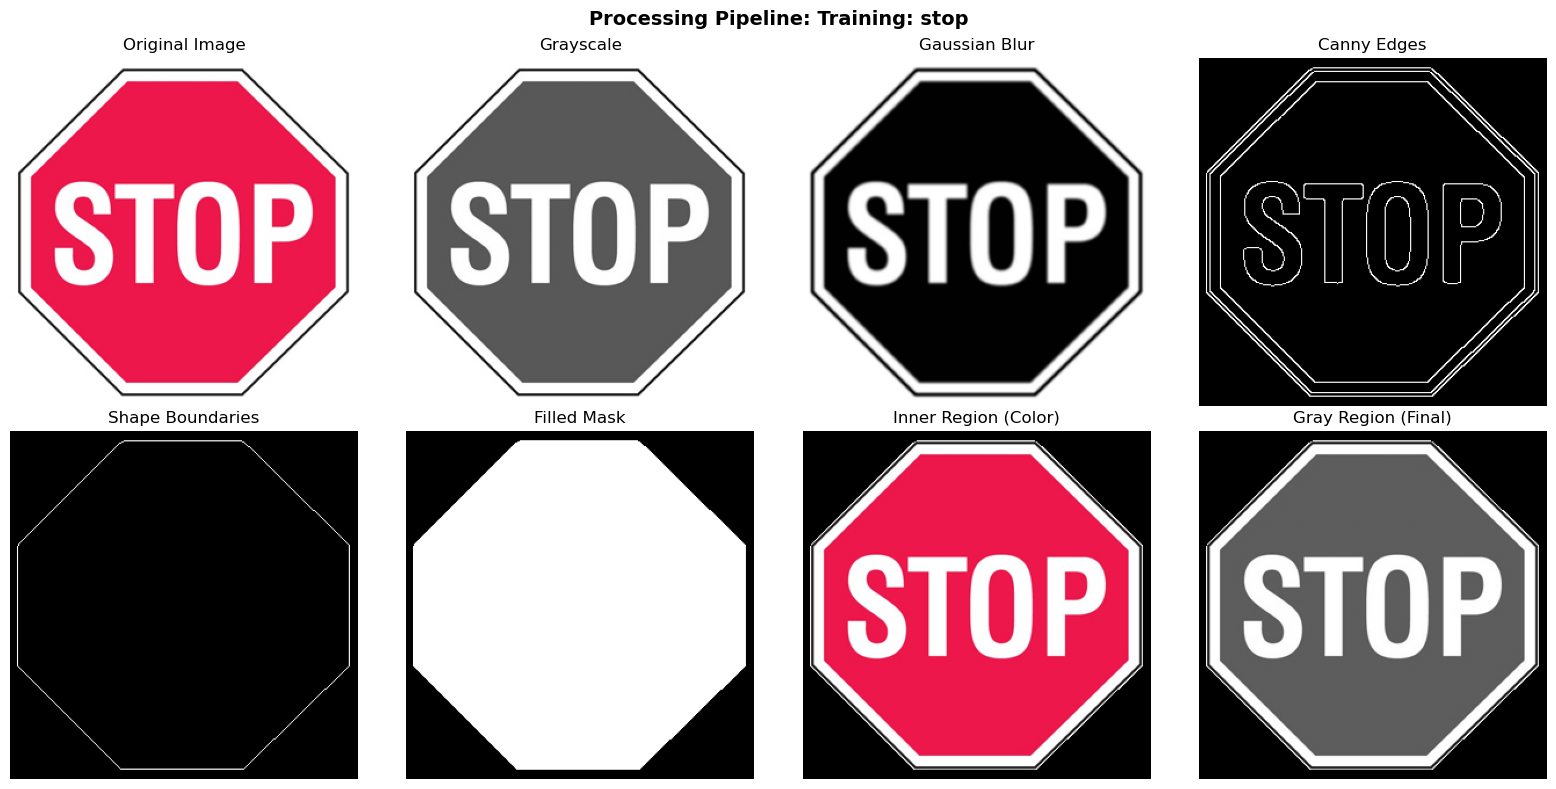

✓ Processed: stop - Hu Moments: [1.19067224e-03 6.64817409e-09 1.73612450e-14 4.17830977e-14]


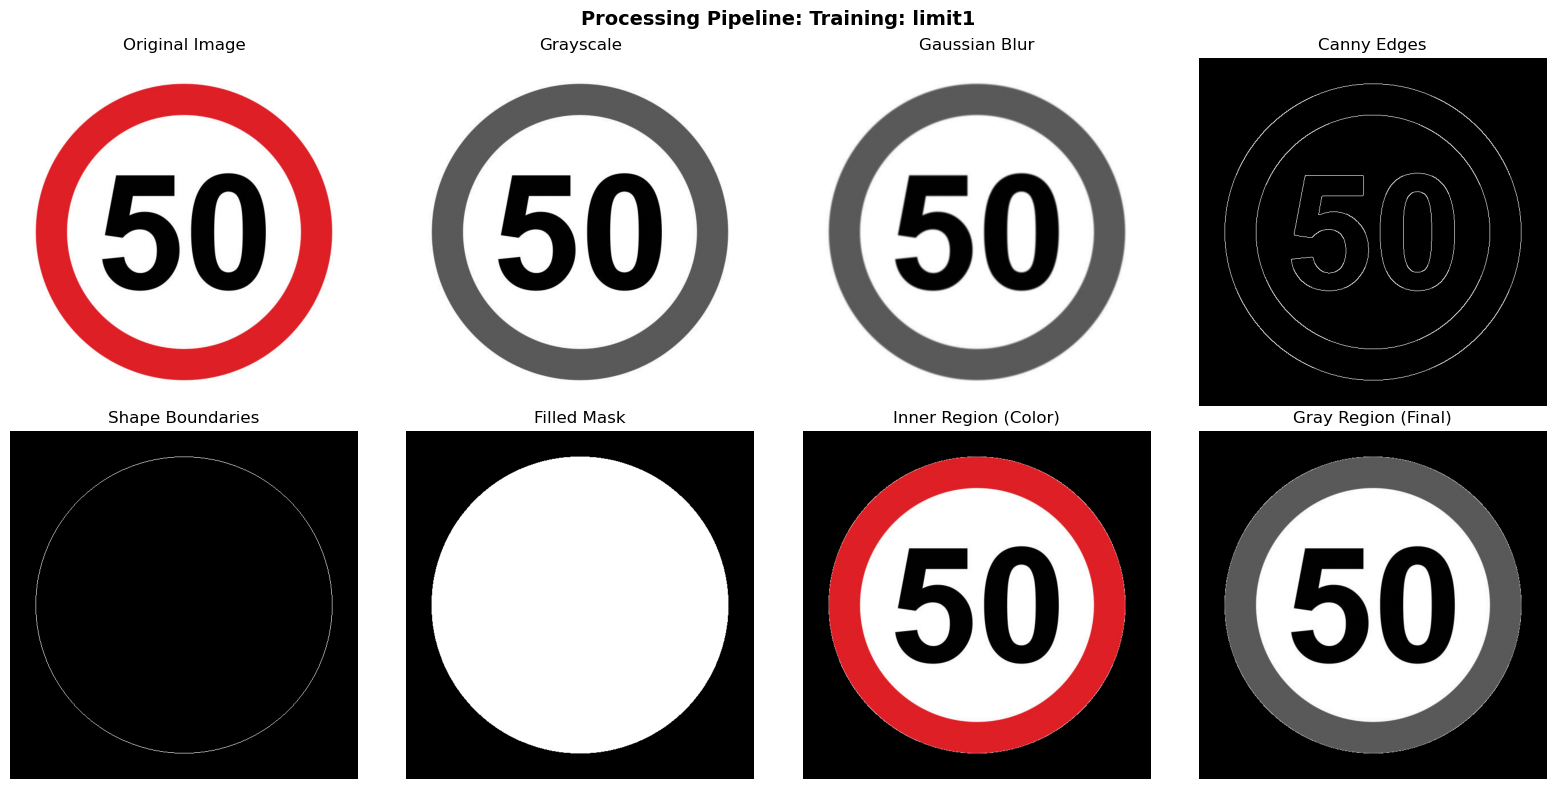

✓ Processed: limit1 - Hu Moments: [9.47102784e-04 7.25192723e-10 2.09889875e-14 5.91067421e-14]


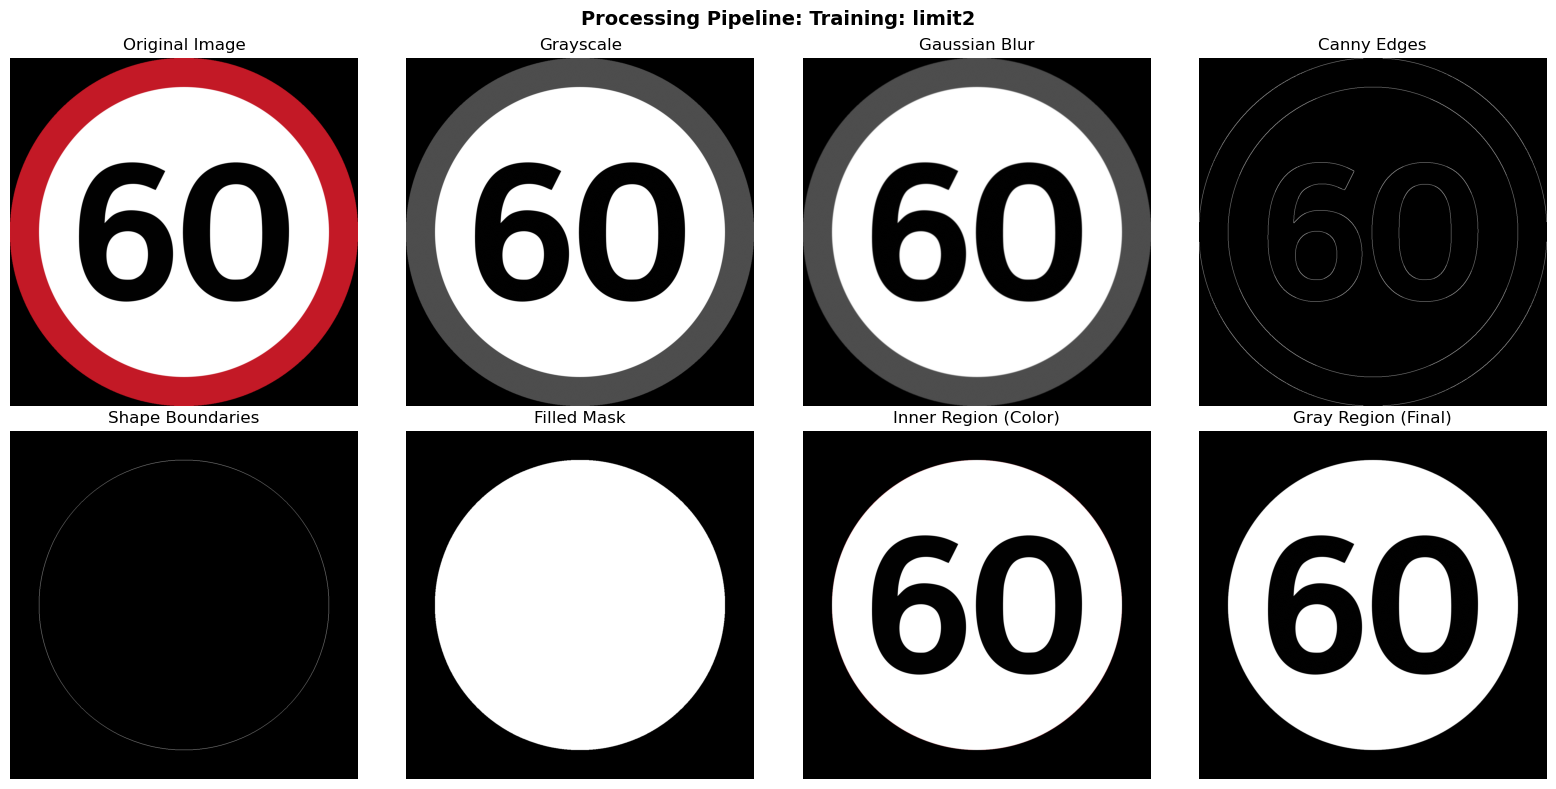

✓ Processed: limit2 - Hu Moments: [9.28689989e-04 3.40745177e-09 2.40176883e-14 1.66799470e-13]


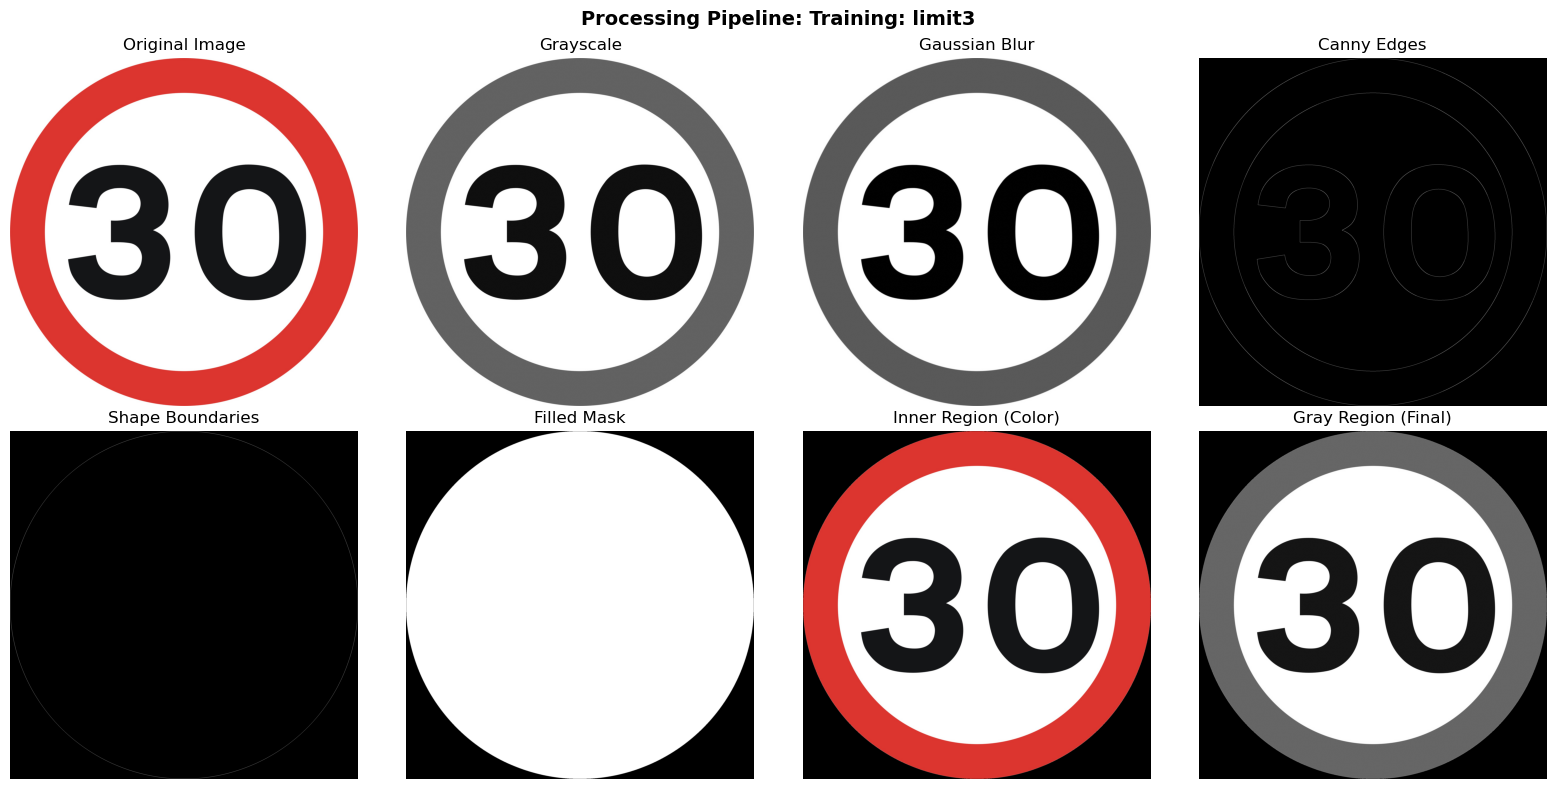

✓ Processed: limit3 - Hu Moments: [9.08350064e-04 2.56887170e-09 2.19499418e-13 8.55104766e-14]


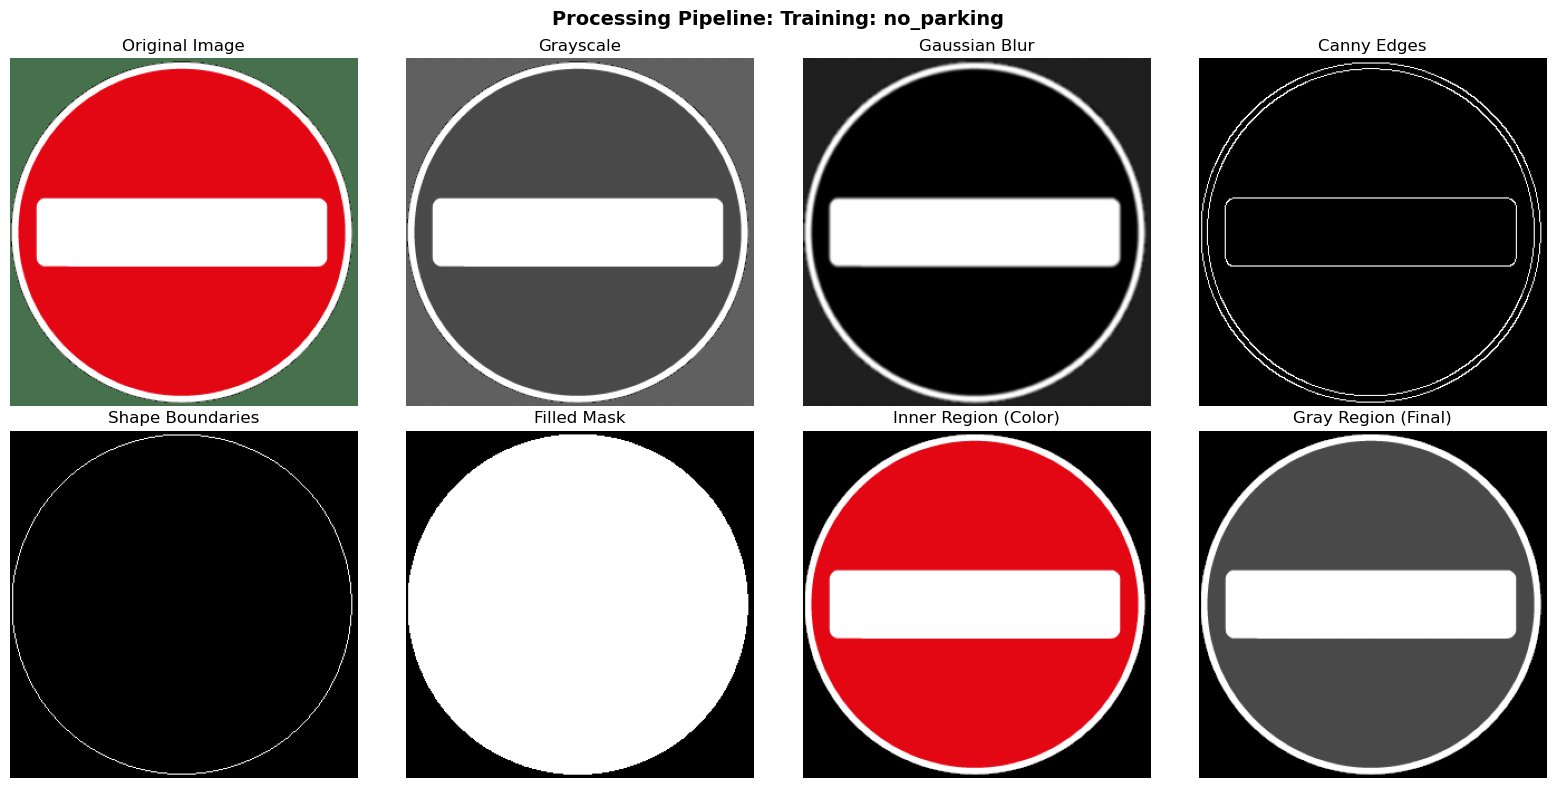

✓ Processed: no_parking - Hu Moments: [1.18677854e-03 3.10569660e-08 4.18843284e-16 7.95776476e-17]


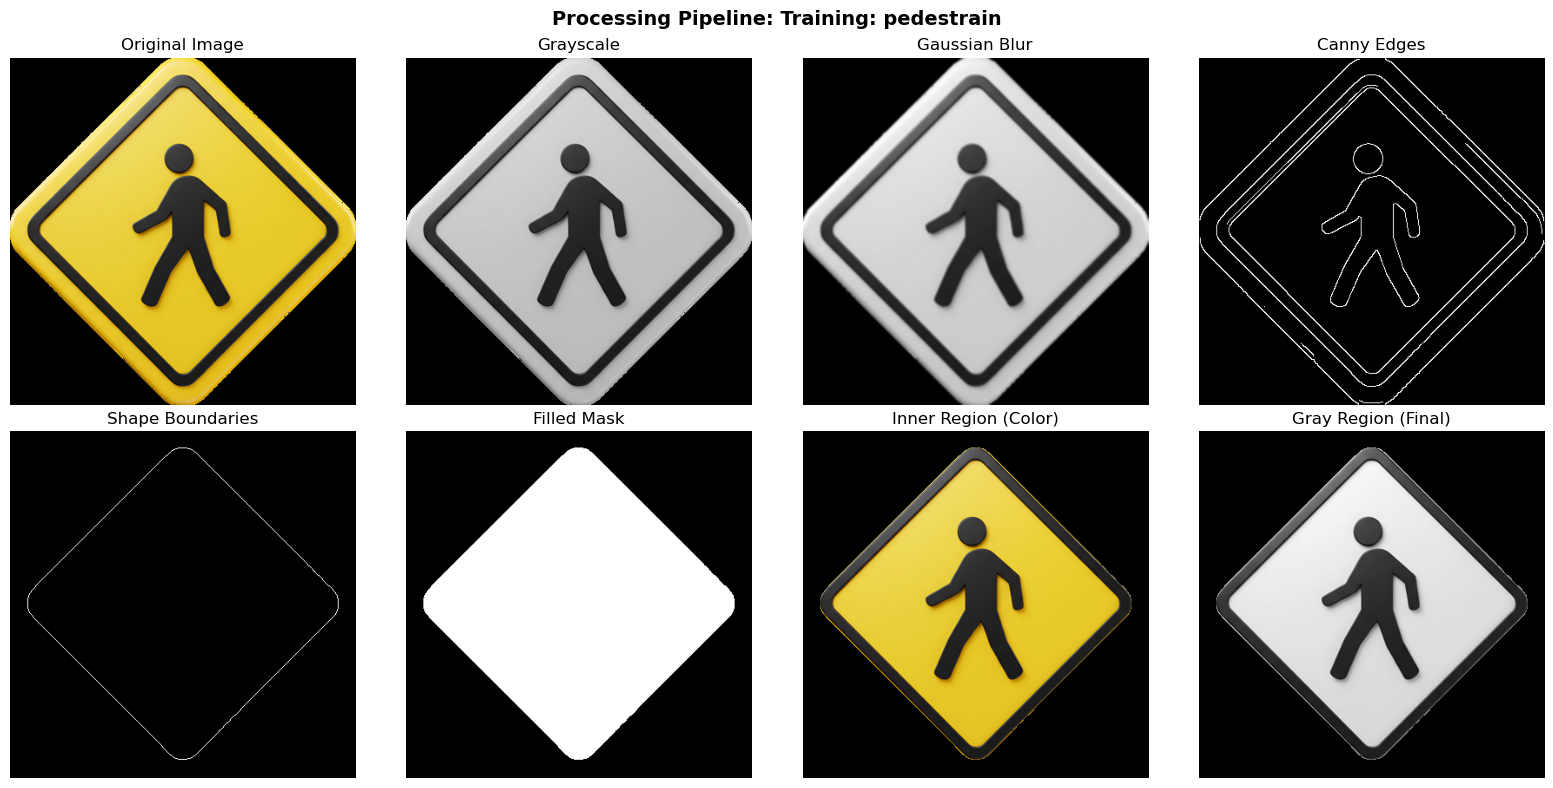

✓ Processed: pedestrain - Hu Moments: [1.05973260e-03 2.04784218e-10 2.99806765e-13 6.83705184e-13]


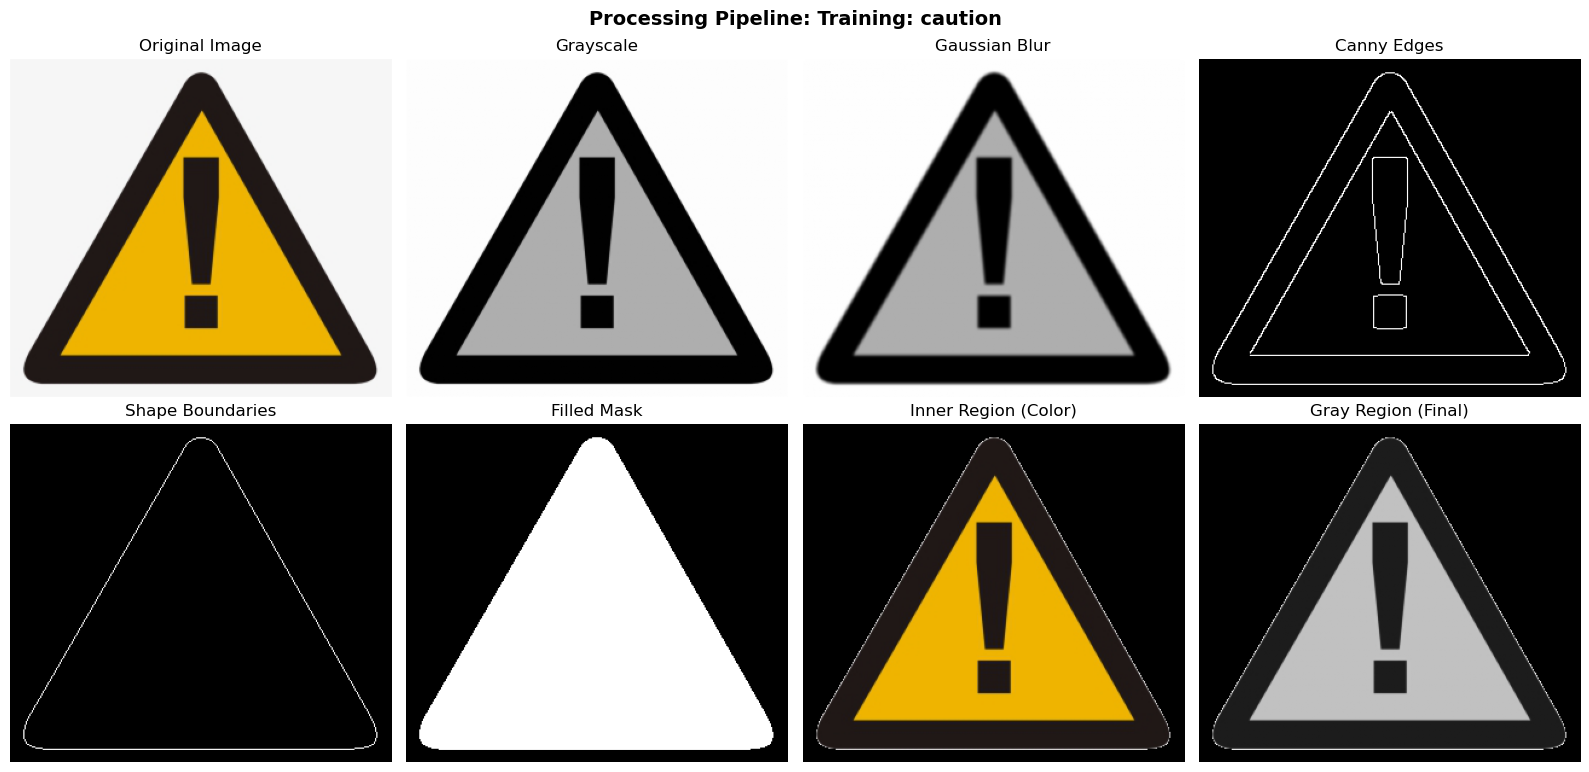

✓ Processed: caution - Hu Moments: [1.38494207e-03 4.07454704e-09 1.59497106e-09 5.83006576e-12]

TESTING PHASE: Matching test images...


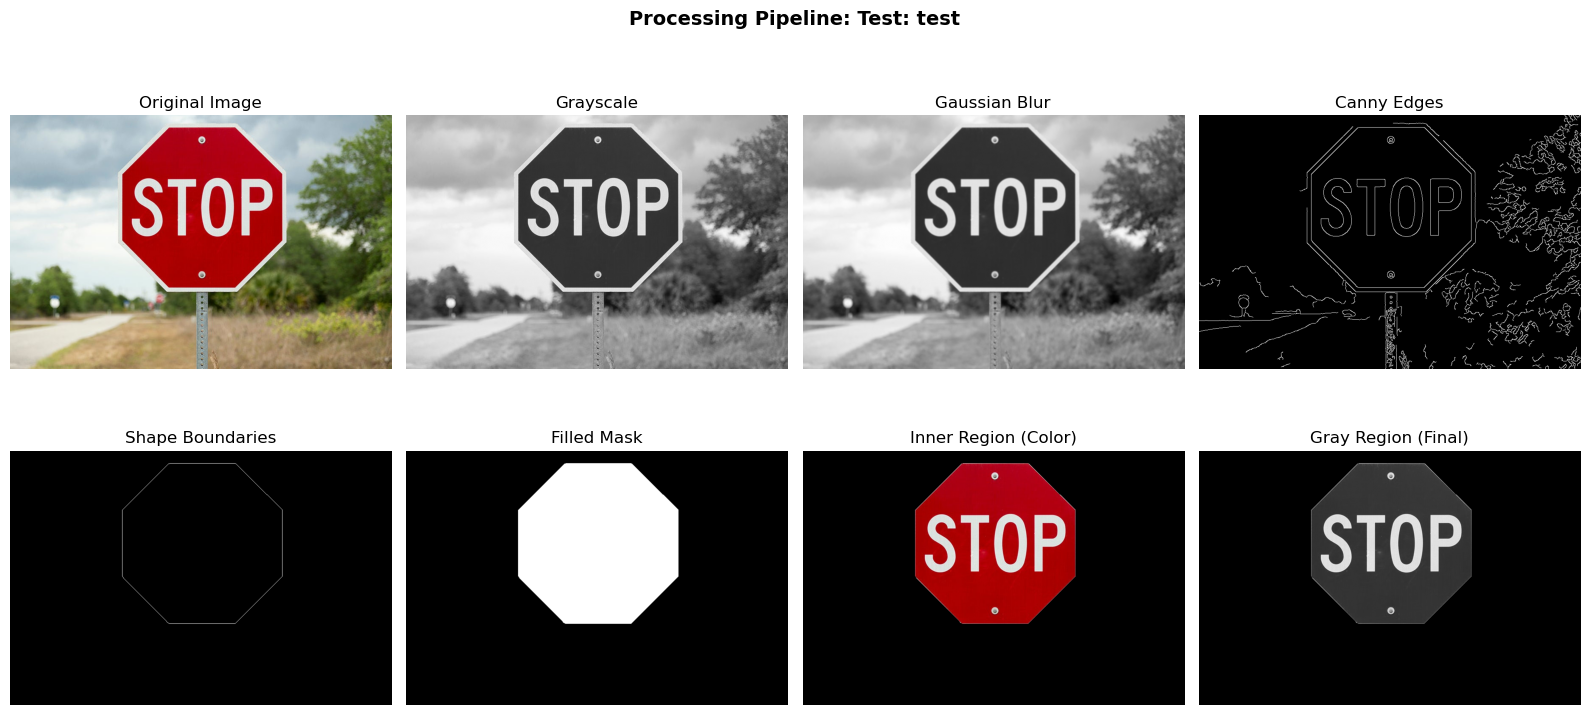

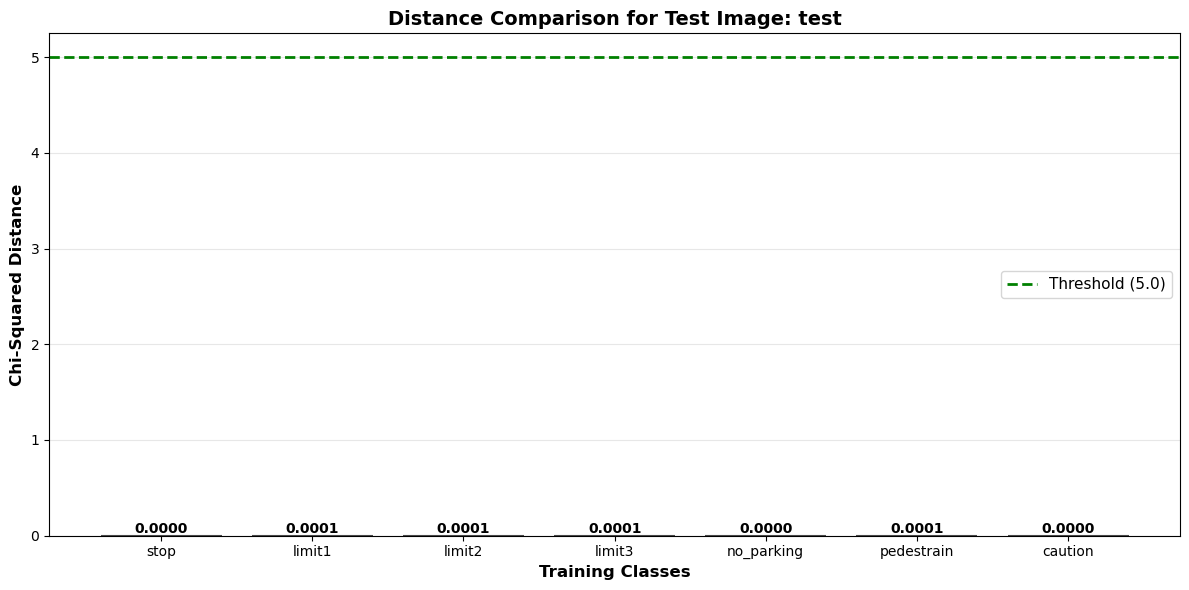

test => caution (distance: 0.000016)

CHI-SQUARED DISTANCE MATRIX
+--------------+---------+----------+----------+----------+--------------+--------------+-----------+----------------+
| Test Image   |    stop |   limit1 |   limit2 |   limit3 |   no_parking |   pedestrain |   caution | Match Result   |
+==============+=========+==========+==========+==========+==============+==============+===========+================+
| test         | 4.5e-05 | 0.000107 | 0.000113 |  0.00012 |      4.6e-05 |      7.4e-05 |   1.6e-05 | caution        |
+--------------+---------+----------+----------+----------+--------------+--------------+-----------+----------------+

MATCHING SUMMARY
Distance Threshold: 5.0
Total Tests: 1
Matches Found: 1
No Match: 0
  ✓ MATCH | test => caution (0.000016)


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from tabulate import tabulate

# ===== PREPROCESSING FUNCTIONS =====
def apply_clahe(gray_image, clip_limit=2.0, tile_size=8):
    """Apply Contrast Limited Adaptive Histogram Equalization"""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size, tile_size))
    return clahe.apply(gray_image)

def gaussian_blur_canny(image, kernel_size=5, canny_low=50, canny_high=150, use_clahe=True):
    
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Apply CLAHE for better lighting normalization
    if use_clahe:
        gray = apply_clahe(gray)
    
    blurred = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    
    edges = cv2.Canny(blurred, canny_low, canny_high)
    
    return edges

def extract_shape_boundaries(image, kernel_size=5, min_area=100):
 
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    result = np.zeros_like(image)
    
    # Filter and draw only significant shape boundaries
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area: 
            cv2.drawContours(result, [contour], -1, 255, 1)
    
    return result

def extract_inner_region(original_image, boundary_image):
 
    mask = boundary_image.copy()
    
    contours, _ = cv2.findContours(boundary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Fill the interior of each contour to create a solid mask
    for contour in contours:
        cv2.fillPoly(mask, [contour], 255)
    
    
    mask_normalized = mask.astype(np.float32) / 255.0
    
    # Apply the mask to preserve original colors
    if len(original_image.shape) == 3:  
        result = original_image.copy().astype(np.float32)
        for i in range(3):
            result[:, :, i] = result[:, :, i] * mask_normalized
        result = result.astype(np.uint8)
    else: 
        result = (original_image.astype(np.float32) * mask_normalized).astype(np.uint8)
    
    return result, mask

# ===== FEATURE EXTRACTION =====
def get_hu_moments(img):
    """Calculate Hu moments for shape descriptor"""
    m = cv2.moments(img.astype(float))
    hu = cv2.HuMoments(m).flatten()
    return hu[:4]

def process_image_pipeline(image_path, plot_intermediate=False, title="", min_area=500):
    """Complete pipeline: read -> detect edges -> extract region -> get Hu moments"""
    img = cv2.imread(image_path, 1)
    
    # Step 1: Edge detection
    edges = gaussian_blur_canny(img)
    
    # Step 2: Extract shape boundaries
    boundaries = extract_shape_boundaries(edges, min_area=min_area)
    
    # Step 3: Extract inner region
    inner_region, mask = extract_inner_region(img, boundaries)
    
    # Step 4: Convert to grayscale
    if len(inner_region.shape) == 3:
        gray_region = cv2.cvtColor(inner_region, cv2.COLOR_BGR2GRAY)
    else:
        gray_region = inner_region
    
    # Step 5: Calculate Hu moments
    hu_moments = get_hu_moments(gray_region)
    
    # Plot intermediate results if requested
    if plot_intermediate:
        # Get intermediate values for plotting
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img.copy()
        
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        fig.suptitle(f'Processing Pipeline: {title}', fontsize=14, fontweight='bold')
        
        # Original image
        axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')
        
        # Grayscale
        axes[0, 1].imshow(gray, cmap='gray')
        axes[0, 1].set_title('Grayscale')
        axes[0, 1].axis('off')
        
        # Blurred
        axes[0, 2].imshow(blurred, cmap='gray')
        axes[0, 2].set_title('Gaussian Blur')
        axes[0, 2].axis('off')
        
        # Edges
        axes[0, 3].imshow(edges, cmap='gray')
        axes[0, 3].set_title('Canny Edges')
        axes[0, 3].axis('off')
        
        # Boundaries
        axes[1, 0].imshow(boundaries, cmap='gray')
        axes[1, 0].set_title('Shape Boundaries')
        axes[1, 0].axis('off')
        
        # Mask
        axes[1, 1].imshow(mask, cmap='gray')
        axes[1, 1].set_title('Filled Mask')
        axes[1, 1].axis('off')
        
        # Inner region
        axes[1, 2].imshow(cv2.cvtColor(inner_region, cv2.COLOR_BGR2RGB))
        axes[1, 2].set_title('Inner Region (Color)')
        axes[1, 2].axis('off')
        
        # Gray region
        axes[1, 3].imshow(gray_region, cmap='gray')
        axes[1, 3].set_title('Gray Region (Final)')
        axes[1, 3].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return hu_moments, inner_region, gray_region

# ===== SIMILARITY MATCHING =====
def calculate_chi2(feature1, feature2):
    """Calculate Chi-squared distance between two feature vectors"""
    eps = 1e-10
    return 0.5 * np.sum((feature1 - feature2) ** 2 / (feature1 + feature2 + eps))

def match_image(test_hu_moments, training_moments, threshold=5.0):
    """
    Match test image with training images
    Returns: (best_match_idx, distance, is_match)
    """
    distances = []
    for train_moment in training_moments:
        dist = calculate_chi2(test_hu_moments, train_moment)
        distances.append(dist)
    
    best_idx = np.argmin(distances)
    best_distance = distances[best_idx]
    is_match = best_distance < threshold
    
    return best_idx, best_distance, is_match, distances

def plot_distance_comparison(training_names, distances, best_idx, test_name, threshold):
    """Plot bar chart comparing distances"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = ['red' if i == best_idx else 'steelblue' for i in range(len(distances))]
    bars = ax.bar(training_names, distances, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add threshold line
    ax.axhline(y=threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold ({threshold})')
    
    # Add value labels on bars
    for i, (bar, dist) in enumerate(zip(bars, distances)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{dist:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_ylabel('Chi-Squared Distance', fontsize=12, fontweight='bold')
    ax.set_xlabel('Training Classes', fontsize=12, fontweight='bold')
    ax.set_title(f'Distance Comparison for Test Image: {test_name}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ===== MAIN WORKFLOW =====

# Step 1: Define training images dictionary
training_images = {
    'stop': 'train/stop.jpg',
    'limit1': 'train/limit1.jpg',
    'limit2': 'train/limit2.png',
    'limit3': 'train/limit3.jpg',
    'no_parking': 'train/nop.png',
    'pedestrain': 'train/pedes.png',
    'caution': 'train/caution.jpg',
}

# Step 2: Process training images and store Hu moments
print("=" * 60)
print("TRAINING PHASE: Processing training images...")
print("=" * 60)

training_moments = []
training_names = list(training_images.keys())

for name, path in training_images.items():
    try:
        hu_moments, _, _ = process_image_pipeline(path, plot_intermediate=True, title=f"Training: {name}")
        training_moments.append(hu_moments)
        print(f"✓ Processed: {name} - Hu Moments: {hu_moments}")
    except Exception as e:
        print(f"✗ Error processing {name}: {e}")

# Step 3: Define test images dictionary
test_images = {
    'test': 'train/test1.jpg',
}

# Step 4: Process test images and compare
print("\n" + "=" * 60)
print("TESTING PHASE: Matching test images...")
print("=" * 60)

DISTANCE_THRESHOLD = 5.0  # Adjust this threshold as needed

results_table = []
matching_results = []

for test_name, test_path in test_images.items():
    try:
        test_hu, test_region, test_gray = process_image_pipeline(
            test_path, plot_intermediate=True, title=f"Test: {test_name}"
        )
        best_idx, best_dist, is_match, all_distances = match_image(
            test_hu, training_moments, threshold=DISTANCE_THRESHOLD
        )
        
        # Plot distance comparison
        plot_distance_comparison(training_names, all_distances, best_idx, test_name, DISTANCE_THRESHOLD)
        
        # Create table row
        row = [test_name]
        for i, dist in enumerate(all_distances):
            row.append(f'{dist:.6f}')
        
        if is_match:
            matched_label = training_names[best_idx]
            result = f"{test_name} => {matched_label} (distance: {best_dist:.6f})"
            row.append(matched_label)
        else:
            result = f"{test_name} => NO MATCH (best distance: {best_dist:.6f})"
            row.append("NO MATCH")
        
        results_table.append(row)
        matching_results.append({
            'test_name': test_name,
            'matched': is_match,
            'match_class': training_names[best_idx] if is_match else "Unknown",
            'distance': best_dist
        })
        
        print(result)
        
    except Exception as e:
        print(f"✗ Error processing test image {test_name}: {e}")

# Step 5: Display results table
print("\n" + "=" * 60)
print("CHI-SQUARED DISTANCE MATRIX")
print("=" * 60)
headers = ['Test Image'] + training_names + ['Match Result']
print(tabulate(results_table, headers=headers, tablefmt='grid'))

# Step 6: Summary
print("\n" + "=" * 60)
print("MATCHING SUMMARY")
print("=" * 60)
print(f"Distance Threshold: {DISTANCE_THRESHOLD}")
print(f"Total Tests: {len(matching_results)}")
matches_found = sum(1 for r in matching_results if r['matched'])
print(f"Matches Found: {matches_found}")
print(f"No Match: {len(matching_results) - matches_found}")

for result in matching_results:
    status = "✓ MATCH" if result['matched'] else "✗ NO MATCH"
    print(f"  {status} | {result['test_name']} => {result['match_class']} ({result['distance']:.6f})")